<a href="https://colab.research.google.com/github/icoretic44/NoProp-/blob/main/NoProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

In [ ]:
# Hyperparameters
T = 10  # Diffusion steps
embed_dim = 10  # Label embedding dimension(No. of Classes)
batch_size = 128
lr = 0.001
epochs = 50
n = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def get_dataloader(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.0,),(1.0,))
    ])
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True,num_workers=4, pin_memory=2)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False,num_workers=4, pin_memory=2)
    return train_loader, test_loader

In [ ]:
train_loader, test_loader = get_dataloader(batch_size)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7ce4284481d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ce33f330650>)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1), #28x28 => 32,26,26
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #32,26,26 => 32,13,13
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 3, 1), #32,13,13 => 64,11,11
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, 3, 1), #64,11,11 => 128,9,9
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #128,9,9 => 128,4,4
            nn.Dropout(0.2),
            nn.Flatten(), # 2048
            nn.Linear(128 * 4 * 4, 256), #Corrected this
            nn.BatchNorm1d(256)
        )
    def forward(self, x):
        return self.features(x)

In [ ]:
class DenoisingMLP(nn.Module):
    def __init__(self):  #embed_dim passed to init
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(256 + embed_dim, 256), #Corrected dim
            nn.BatchNorm1d(256),  #Change: BatchNorm1d, not 2d
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  #Change: BatchNorm1d, not 2d
            nn.ReLU(),
            nn.Linear(128, embed_dim) #No flatten needed
        )
    def forward(self, x_features, z_t_1):
        combined = torch.cat((x_features, z_t_1), dim=1)
        return self.mlp(combined)

In [ ]:
cnn = CNN().to(device)
mlps = nn.ModuleList([DenoisingMLP().to(device) for _ in range(T)])  # One MLP per layer
optimizers = [optim.Adam(mlp.parameters(), lr=lr) for mlp in mlps]
cnn, mlps, optimizers

(CNN(
   (features): Sequential(
     (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.2, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
     (5): ReLU()
     (6): Dropout(p=0.2, inplace=False)
     (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
     (8): ReLU()
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Dropout(p=0.2, inplace=False)
     (11): Flatten(start_dim=1, end_dim=-1)
     (12): Linear(in_features=2048, out_features=256, bias=True)
     (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
 ),
 ModuleList(
   (0-9): 10 x DenoisingMLP(
     (mlp): Sequential(
       (0): Linear(in_features=266, out_features=256, bias=True)
       (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2):

In [ ]:
def get_coefficient(alpha_list: list):
  """
  a~[t] = cummulative_product(alpha_list)
  a_[t] = sqrt(a~[t] * (1- a~[t-1]))
  b_[t] = sqrt(a~[t-1] * (1- a~[t]))
  c_[t] = ((1-a~[t])*(1-a~[t-1])) / (1-a~[t-1])
  """
  alpha_tidal = torch.cumprod(alpha_list,dim=0)
  # Change: Create a 1-element tensor with shape (1) to make it a sequence
  # Fix: Move the tensor to the same device as alpha_tidal
  alpha_tidal_previous = torch.cat((torch.Tensor([1.0]).to(alpha_list.device),alpha_tidal[:-1]))
  a_t = alpha_tidal * (1-alpha_tidal_previous)
  b_t = alpha_tidal_previous * (1-alpha_tidal)
  c_t = ((1-alpha_tidal)*(1-alpha_tidal_previous)) / (1e-8 + (1-alpha_tidal_previous))
  return a_t,b_t,c_t

In [ ]:
alpha_list = torch.linspace(0.99, 0.9, 10).to(device)
alpha_tidal = torch.cumprod(alpha_list,dim=0)
a_t,b_t,c_t = get_coefficient(alpha_list)
print(f"alpha_tidal = {alpha_tidal}")
a_t,b_t,c_t

alpha_tidal = tensor([0.9900, 0.9702, 0.9411, 0.9035, 0.8583, 0.8068, 0.7503, 0.6903, 0.6282,
        0.5653], device='cuda:0')


(tensor([0.0000, 0.0097, 0.0280, 0.0532, 0.0829, 0.1143, 0.1450, 0.1724, 0.1946,
         0.2102], device='cuda:0'),
 tensor([0.0100, 0.0295, 0.0572, 0.0909, 0.1280, 0.1658, 0.2014, 0.2324, 0.2567,
         0.2730], device='cuda:0'),
 tensor([0.0000, 0.0298, 0.0589, 0.0965, 0.1417, 0.1932, 0.2497, 0.3097, 0.3718,
         0.4347], device='cuda:0'))

In [ ]:
def compute_zt(zt_1, u_theta_output, a_t, b_t, c_t):
    """Computes z_t given z_{t-1}, a_t, b_t, c_t, and neural network output."""
    eps = torch.randn_like(zt_1).to(device)
    z_t = (a_t * u_theta_output + b_t * zt_1 + torch.sqrt(c_t) * eps).to(device)
    return z_t

*** Test function ***

In [ ]:
def loss_metric(u_theta_out, u_y,t):
  #calculate SNR
  snr_t = alpha_tidal[t] / (1-alpha_tidal[t])
  snr_t1 = alpha_tidal[t-1] / (1-alpha_tidal[t-1])

  return T*n/(2*batch_size) * torch.mean((u_theta_out - u_y) ** 2) * torch.abs(snr_t - snr_t1)

In [ ]:
#training
for epoch in range(epochs):
  epoch_loss = 0.0 # Change: Initialize epoch_loss for each epoch
  batch_count = 0

  for x,y in train_loader:
    current_batch_size = x.shape[0] # Change: Get the batch size as an integer
    #print(f"current_batch_size = {current_batch_size}")
    x = x.to(device)
    y = y.to(device)

    # Forward pass
    x_features = cnn(x)
    #print(f"x_features after CNN ={x_features.shape}")
    u_y = torch.zeros(current_batch_size,embed_dim,device=device).scatter_(1,y.unsqueeze(1),1) # Now current_batch_size is an integer
    #print(f"u_y = {u_y.shape}")
    z = [u_y]
    # forward pass
    for t in range(1,T):
      u_theta_output = mlps[t](x_features,z[t-1].detach())

      z_t = compute_zt(z[t-1],u_theta_output,a_t[t-1],b_t[t-1],c_t[t-1])
      # print(f"z_t={z_t}")
      # print(f"z[t-1] = {z[t-1]}")
      # print(f"u_theta_output = {u_theta_output}")
      # print(f"a_t[t-1] = {a_t[t-1]}")
      # print(f"b_t[t-1] = {b_t[t-1]}")
      # print(f"c_t[t-1] = {c_t[t-1]}")
      z.append(z_t)
      #print(f"z[{t}] = {z}")
    # train MLP
    losses = []
    for t in range(T):
      u_theta_output = mlps[t](x_features,z[t-1].detach())
      loss = loss_metric(u_theta_output,u_y,t)
      #print(loss)
      losses.append(loss)

    # Change: Calculate loss and perform backpropagation inside the loop
    loss_total = sum(losses)

    # Change: Check for NaN loss
    if torch.isnan(loss_total):
        print("Loss is NaN. Breaking training loop.")
        break # Exit the inner loop

    for opt in optimizers:
      opt.zero_grad()
    loss_total.backward() # Change: Backpropagate for the current batch
    for opt in optimizers:
      opt.step()

    epoch_loss += loss_total.item() # Change: Accumulate loss for the epoch
    batch_count += 1

  # Change: Check for NaN average loss
  if batch_count > 0: # Avoid division by zero if the inner loop breaks
    avg_loss = epoch_loss / batch_count
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f}")
  else:
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: NaN")
    break # Exit the outer loop if the inner loop broke due to NaN loss

# Final message
print("Training complete!")

Epoch 1/50 | Avg Loss: 0.0000
Epoch 2/50 | Avg Loss: 0.0000
Epoch 3/50 | Avg Loss: 0.0000
Epoch 4/50 | Avg Loss: 0.0000
Epoch 5/50 | Avg Loss: 0.0000
Epoch 6/50 | Avg Loss: 0.0000
Epoch 7/50 | Avg Loss: 0.0000
Epoch 8/50 | Avg Loss: 0.0000
Epoch 9/50 | Avg Loss: 0.0000
Epoch 10/50 | Avg Loss: 0.0000
Epoch 11/50 | Avg Loss: 0.0000
Epoch 12/50 | Avg Loss: 0.0000
Epoch 13/50 | Avg Loss: 0.0000
Epoch 14/50 | Avg Loss: 0.0000
Epoch 15/50 | Avg Loss: 0.0000
Epoch 16/50 | Avg Loss: 0.0000
Epoch 17/50 | Avg Loss: 0.0000
Epoch 18/50 | Avg Loss: 0.0000
Epoch 19/50 | Avg Loss: 0.0000
Epoch 20/50 | Avg Loss: 0.0000
Epoch 21/50 | Avg Loss: 0.0000
Epoch 22/50 | Avg Loss: 0.0000
Epoch 23/50 | Avg Loss: 0.0000
Epoch 24/50 | Avg Loss: 0.0000
Epoch 25/50 | Avg Loss: 0.0000
Epoch 26/50 | Avg Loss: 0.0000
Epoch 27/50 | Avg Loss: 0.0000
Epoch 28/50 | Avg Loss: 0.0000
Epoch 29/50 | Avg Loss: 0.0000
Epoch 30/50 | Avg Loss: 0.0000
Epoch 31/50 | Avg Loss: 0.0000
Epoch 32/50 | Avg Loss: 0.0000
Epoch 33/50 | Avg

In [ ]:
# prompt: write a evaluation part for this

cnn.eval()  # Set the CNN model to evaluation mode
for mlp in mlps:
    mlp.eval() # Set the MLPs to evaluation mode
# Evaluation
correct_predictions = 0
total_samples = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        x_features = cnn(x)

        # Initialize z with the one-hot encoded labels
        current_batch_size = x.shape[0]
        u_y = torch.zeros(current_batch_size, embed_dim, device=device).scatter_(1, y.unsqueeze(1), 1)
        z = [u_y]

        # Forward pass through the diffusion model
        for t in range(1, T):
            u_theta_output = mlps[t](x_features, z[t-1])
            z_t = compute_zt(z[t-1], u_theta_output, a_t[t-1], b_t[t-1], c_t[t-1])
            z.append(z_t)

        # Get the final predicted label
        u_theta_output = mlps[T-1](x_features, z[T-2],t)
        predicted_labels = torch.argmax(u_theta_output,dim=1)

        # Update metrics
        correct_predictions += (predicted_labels == y).sum().item()
        total_samples += y.size(0)

# Calculate accuracy
accuracy = 100 * correct_predictions / total_samples
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.78%


In [ ]:
# prompt: write a model to use again

# Save the model
torch.save(cnn.state_dict(), 'cnn_model.pth')
for i, mlp in enumerate(mlps):
    torch.save(mlp.state_dict(), f'mlp_model_{i}.pth')

# Load the model
cnn_loaded = CNN().to(device)
cnn_loaded.load_state_dict(torch.load('cnn_model.pth'))

mlps_loaded = nn.ModuleList([DenoisingMLP().to(device) for _ in range(T)])
for i, mlp in enumerate(mlps_loaded):
    mlp.load_state_dict(torch.load(f'mlp_model_{i}.pth'))

cnn_loaded.eval()
for mlp in mlps_loaded:
    mlp.eval()


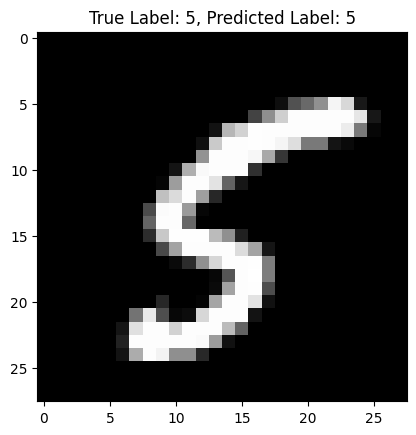

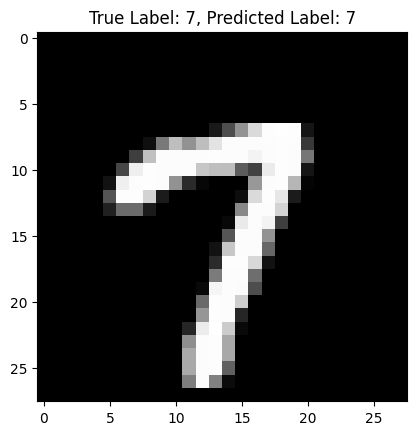

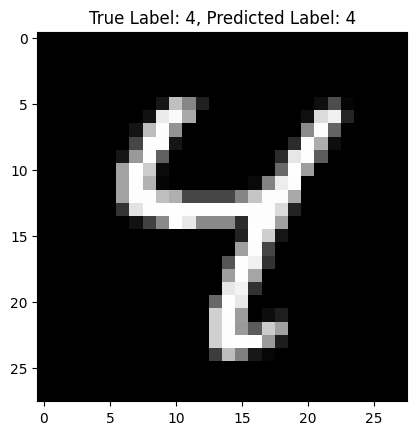

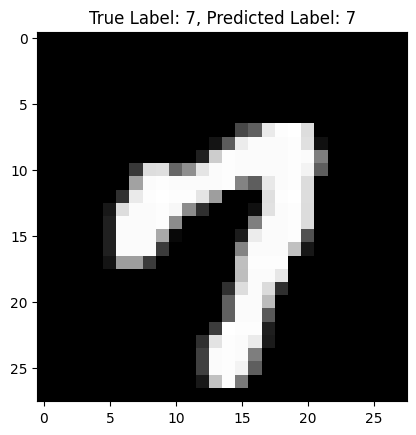

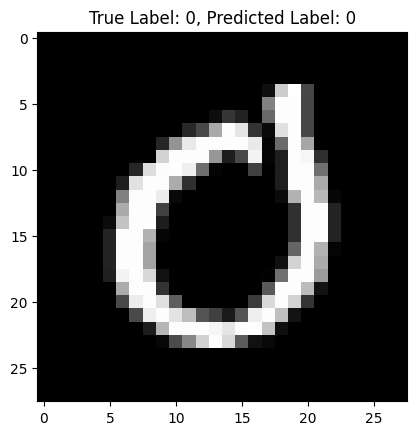

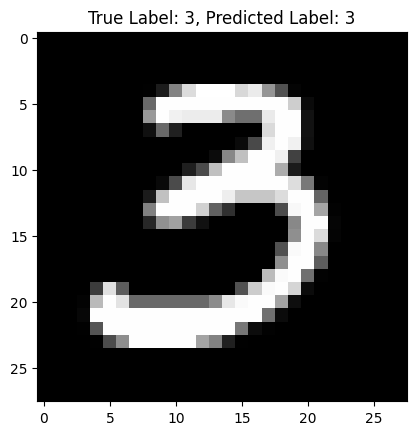

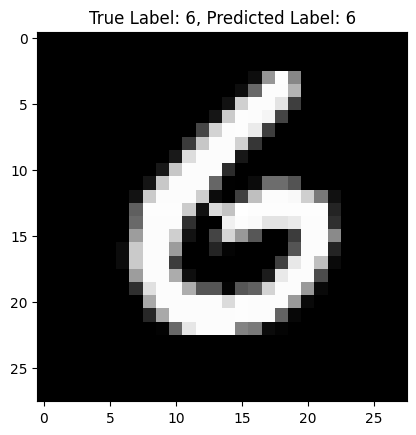

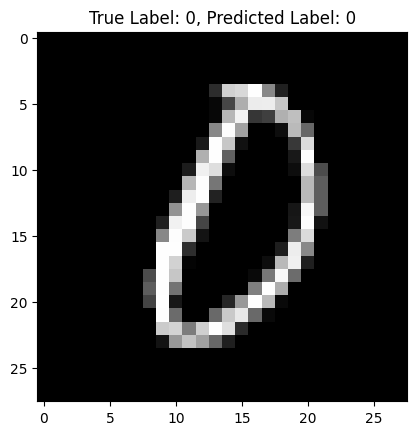

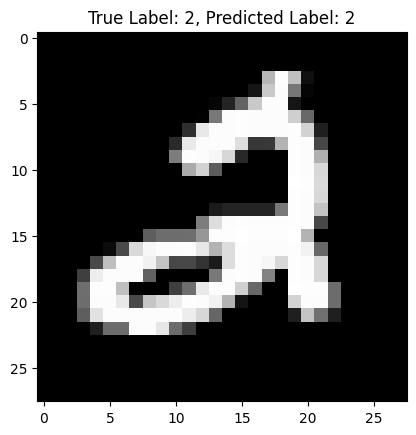

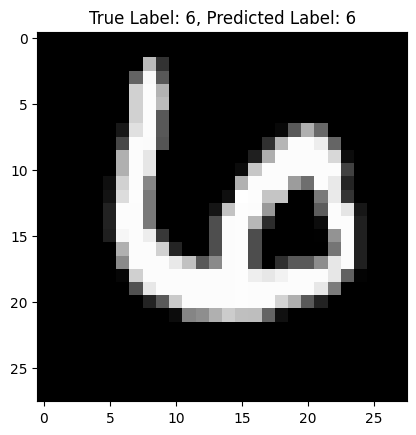

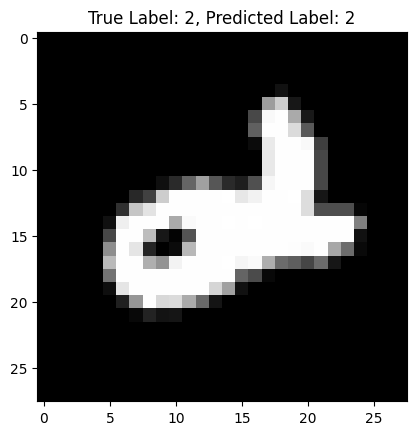

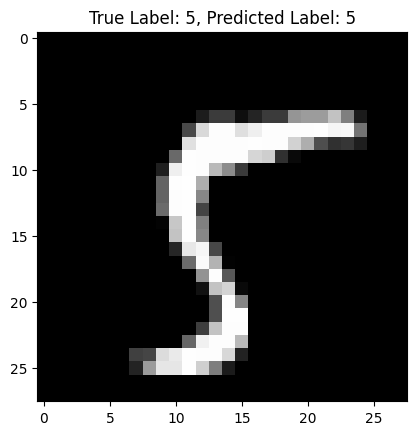

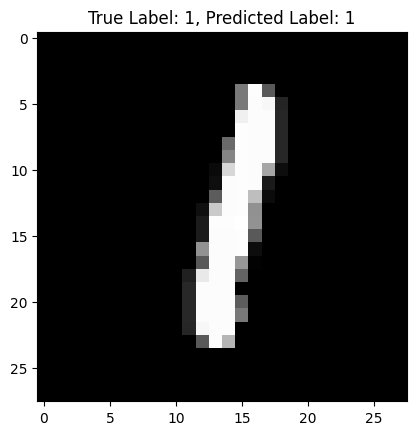

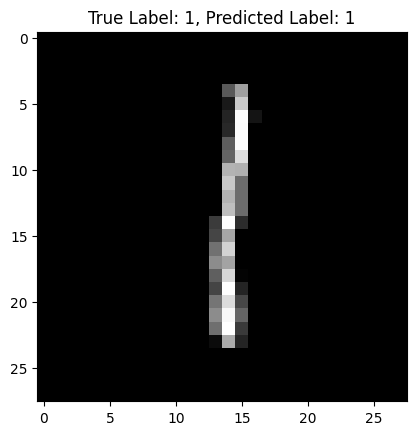

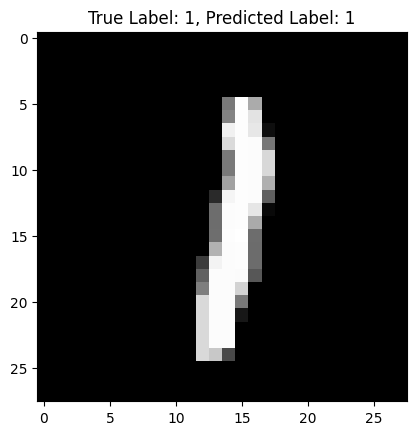

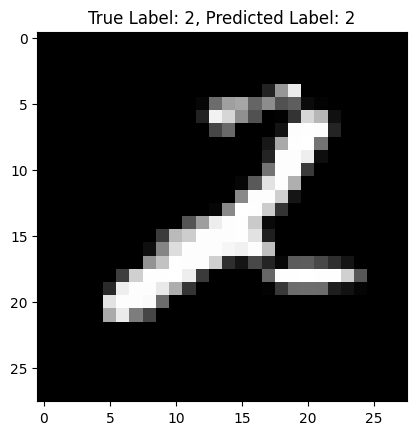

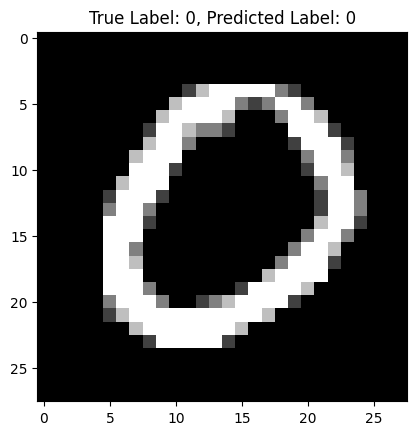

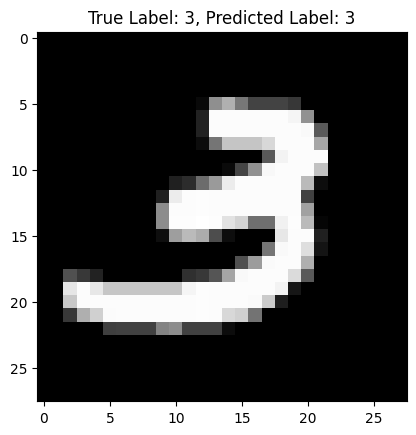

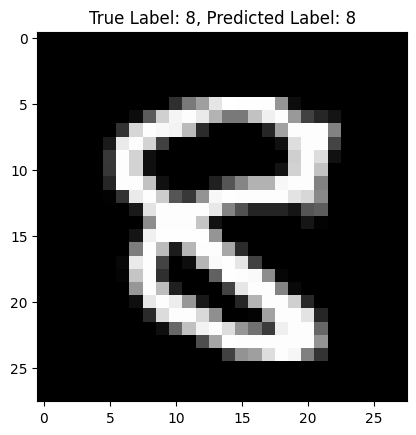

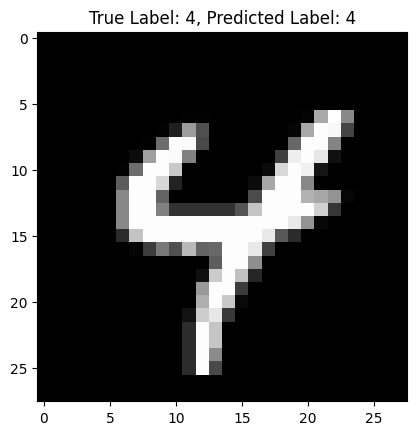

In [ ]:
import random

def predict_and_plot_random_samples(num_samples=20):
    random_indices = random.sample(range(len(test_loader.dataset)), num_samples)
    with torch.no_grad():
        for index in random_indices:
            x, y = test_loader.dataset[index]
            x = x.unsqueeze(0).to(device)  # Add batch dimension

            x_features = cnn_loaded(x)
            current_batch_size = x.shape[0]

            # Convert y to a tensor and ensure it's on the correct device
            y = torch.tensor(y, device=device, dtype=torch.int64)

            # Scatter along dimension 1 (columns) with proper index shape
            u_y = torch.zeros(current_batch_size, embed_dim, device=device).scatter_(1, y.view(-1, 1), 1)
            z = [u_y]

            for t in range(1, T):
                u_theta_output = mlps_loaded[t](x_features, z[t-1])
                z_t = compute_zt(z[t-1], u_theta_output, a_t[t-1], b_t[t-1], c_t[t-1])
                z.append(z_t)

            u_theta_output = mlps_loaded[T-1](x_features, z[T-2])
            predicted_label = torch.argmax(u_theta_output, dim=1).item()

            # Plotting
            plt.figure()
            plt.imshow(x.cpu().squeeze(), cmap='gray')  # Squeeze removes batch and channel dimensions
            plt.title(f"True Label: {y.item()}, Predicted Label: {predicted_label}")
            plt.show()

# Call the function to predict and plot 5 random samples
predict_and_plot_random_samples()